# Setup
Here is some functions and data I need for this notebook.

In [1]:
import sys

[print(f"sys.path.append('{s}')") for s in sys.path]

sys.path.append('/Users/colefritsch/ENCORE/Python_ENCORE/Notebook_Records')
sys.path.append('/tmp')
sys.path.append('/Users/colefritsch/opt/anaconda3/lib/python38.zip')
sys.path.append('/Users/colefritsch/opt/anaconda3/lib/python3.8')
sys.path.append('/Users/colefritsch/opt/anaconda3/lib/python3.8/lib-dynload')
sys.path.append('')
sys.path.append('/Users/colefritsch/opt/anaconda3/lib/python3.8/site-packages')
sys.path.append('/Users/colefritsch/opt/anaconda3/lib/python3.8/site-packages/aeosa')
sys.path.append('/Users/colefritsch/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions')
sys.path.append('/Users/colefritsch/.ipython')


[None, None, None, None, None, None, None, None, None, None]

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

import FileReader

def plot_ecdf(X, E0=0.0, color='k', Density:bool=False, label:str=None, rev:bool=False):
    N = len(X)
    if rev:
        if Density:
            plt.hlines(1.0, E0, X[0], color, label=label)
        else:
            plt.hlines(N, E0, X[0], color, label=label)
    else:
        plt.hlines(0.0, E0, X[0], color, label=label)
    if rev:
        if Density:
            [plt.hlines((N-idx)/N, X[idx-1], X[idx], color) for idx in range(1,N)]
            [plt.vlines(x, (N-idx-1)/N, (N-idx)/N, color) for idx, x in enumerate(X)]
        else:
            [plt.hlines(N-idx, X[idx-1], X[idx], color) for idx in range(1,N)]
            [plt.vlines(x, N-idx-1, N-idx, color) for idx, x in enumerate(X)]
    else:
        if Density:
            [plt.hlines(idx/N, X[idx-1], X[idx], color) for idx in range(1,N)]
            [plt.vlines(x, idx/N, (idx+1)/N, color) for idx, x in enumerate(X)]
        else:
            [plt.hlines(idx, X[idx-1], X[idx], color) for idx in range(1,N)]
            [plt.vlines(x, idx, (idx+1), color) for idx, x in enumerate(X)]
def eval_ecdf(X, D, Density:bool=False):
    N = len(D)
    i = 0;  d = D[i]
    X.sort()
    Y = np.zeros(len(X))
    for j,x in enumerate(X):
        while x >= d:
            i += 1
            if i != N:  d = D[i]
            else:       d = math.inf
        if Density:     Y[j] = i / N
        else:           Y[j] = i
    return Y

# E, Gn, Gg, SG_type = FileReader.readSammyPar('/Users/colefritsch/ENCORE/Python_ENCORE/SAMQUA.PAR')
E, Gn, Gg, SG_type = FileReader.readSammyPar('/Users/colefritsch/ENCORE/Python_ENCORE/SAMNDF (3).PAR')
EA = E[SG_type==0]
EB = E[SG_type==1]

Bounds = (0,2550)

# Mean Neutron Widths

...

truncation location = 0.50000
Mean Neutron Width  = 46.37556
Percent Missing = 8.270%


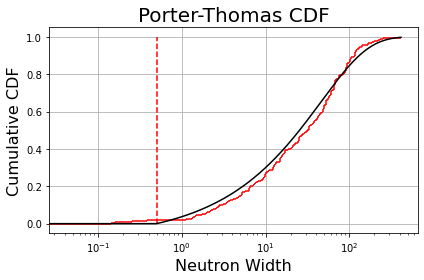

truncation location = 0.50000
Mean Neutron Width  = 35.45528
Percent Missing = 9.453%


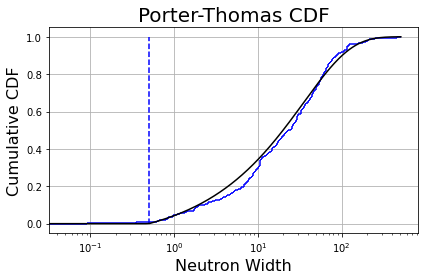

In [3]:
from scipy.special import gamma, gammainc, gammaincc
from scipy.optimize import curve_fit

import RMatrix

def PorterThomas(Gn, Gnm:float=1.0, trunc:float=0.0, nu:int=1):
    if trunc == 0.0:
        prob = nu*(nu*Gn/(2*Gnm))**(nu/2-1) * np.exp(-nu*Gn/(2*Gnm)) / (2 * Gnm * gamma(nu/2))
    else:
        prob = np.zeros(len(Gn))
        prob[Gn >  trunc] = nu*(nu*Gn[Gn >  trunc]/(2*Gnm))**(nu/2-1) * np.exp(-nu*Gn[Gn >  trunc]/(2*Gnm)) / (2 * Gnm * gamma(nu/2) * gammaincc(nu/2, nu*trunc/(2*Gnm)))
        prob[Gn <= trunc] = 0.0
    return prob
def PorterThomasCDF(Gn, Gnm:float=1.0, trunc:float=0.0, nu:int=1):
    if trunc == 0.0:
        prob = gammainc(nu/2, nu*Gn/(2*Gnm))
    else:
        prob = np.zeros(len(Gn))
        prob[Gn >  trunc] = (gammainc(nu/2, nu*Gn[Gn >= trunc]/(2*Gnm))-gammainc(nu/2, nu*trunc/(2*Gnm))) / gammaincc(nu/2, nu*trunc/(2*Gnm))
        prob[Gn <= trunc] = 0.0
    return prob
def PercentMissing(trunc:float, Gnm:float=1.0, nu:int=1):
    return gammainc(nu/2, nu*trunc/(2*Gnm))
def FitPorterThomas(rGn, nu:int=1, trunc:float=None):
    X = np.linspace(0,1500,10000)
    Y = eval_ecdf(X, rGn, Density=True)
    if trunc is None:
        def func(X_, Gnm_, trunc_):     return PorterThomasCDF(X_, Gnm_, trunc_, nu)
        params = curve_fit(func, X, Y, (np.mean(rGn), np.min(rGn)))[0]
        return params[0], params[1]
    else:
        def func(X_, Gnm_):     return PorterThomasCDF(X_, Gnm_, trunc, nu)
        params = curve_fit(func, X, Y, np.mean(rGn), bounds=(0.0,np.max(rGn)))[0]
        return params[0], trunc


l = 0
A = 181
ac = RMatrix.NuclearRadius(A)
rGn = Gn * RMatrix.ReduceFactor(E, l, A, ac)
rGnA = rGn[SG_type == 0]
rGnA.sort()
rGnB = rGn[SG_type == 1]
rGnB.sort()

lims = (90,90)

# GnmA, truncA = FitPorterThomas(rGnA, trunc=np.min(rGnA))
# GnmB, truncB = FitPorterThomas(rGnB, trunc=np.min(rGnB))
GnmA, truncA = FitPorterThomas(rGnA, trunc=0.5)
GnmB, truncB = FitPorterThomas(rGnB, trunc=0.5)
XA = np.linspace(0,np.max(rGnA),10000)
YA = PorterThomasCDF(XA, GnmA, truncA)
XB = np.linspace(0,np.max(rGnB),10000)
YB = PorterThomasCDF(XB, GnmB, truncB)

MissA = PercentMissing(truncA, GnmA)
MissB = PercentMissing(truncB, GnmB)

print(f'truncation location = {truncA:.5f}')
print(f'Mean Neutron Width  = {GnmA:.5f}')
print(f'Percent Missing = {100*MissA:.3f}%')

plt.figure()
plt.vlines(truncA, 0.0, 1.0, colors='r', linestyles='--')
plt.plot(XA,YA,'-k')
plot_ecdf(rGnA, color='r', Density=True)
plt.xscale('log')
plt.title('Porter-Thomas CDF', fontsize=20)
plt.xlabel('Neutron Width', fontsize=16)
plt.ylabel('Cumulative CDF', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'truncation location = {truncB:.5f}')
print(f'Mean Neutron Width  = {GnmB:.5f}')
print(f'Percent Missing = {100*MissB:.3f}%')

plt.figure()
plt.vlines(truncB, 0.0, 1.0, colors='b', linestyles='--')
plt.plot(XB,YB,'-k')
plot_ecdf(rGnB, color='b', Density=True)
plt.xscale('log')
plt.title('Porter-Thomas CDF', fontsize=20)
plt.xlabel('Neutron Width', fontsize=16)
plt.ylabel('Cumulative CDF', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

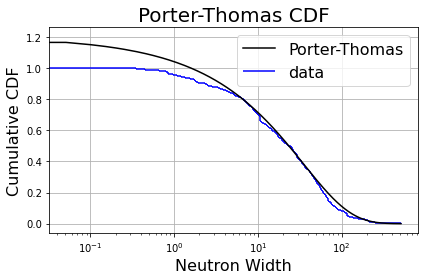

In [4]:
XB = np.linspace(0,np.max(rGnB),10000)
YB = PorterThomasCDF(XB, GnmB, 0)
ZB = (1-YB)*1.2

plt.figure()
plt.plot(XB,ZB,'-k', label='Porter-Thomas')
plot_ecdf(rGnB, color='b', Density=True, rev=True, label='data')
plt.xscale('log')
plt.title('Porter-Thomas CDF', fontsize=20)
plt.xlabel('Neutron Width', fontsize=16)
plt.ylabel('Cumulative CDF', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

This distribution is for a reduced width cutoff. We want a normal width cutoff factor ...

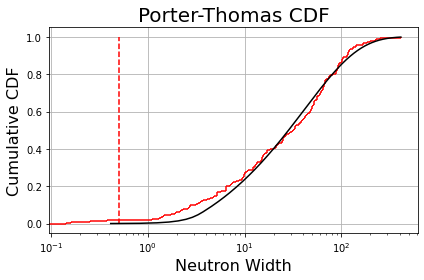

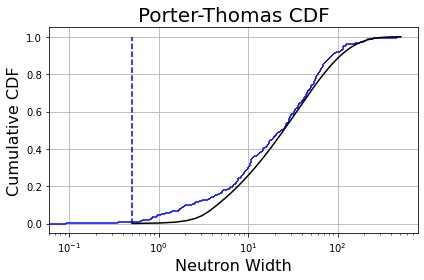

In [5]:
from scipy.integrate import cumtrapz
G0 = np.min(Gn)

def new_PT(G, EB, Gnm, trunc):
    N = 1000
    Es = np.linspace(*EB, N)
    prob = np.zeros(G.shape)
    for E_ in Es:
        prob += PorterThomas(G, Gnm, G0*np.sqrt(E_))
    cumprob = cumtrapz(prob, G)
    return cumprob

XA = np.linspace(1e-3, np.max(rGnA), 1000)
YA = new_PT(XA, Bounds, GnmA*0.9, G0)/1000

XB = np.linspace(1e-3, np.max(rGnB), 1000)
YB = new_PT(XB, Bounds, GnmB, G0)/1000

plt.figure()
plt.vlines(truncA, 0.0, 1.0, colors='r', linestyles='--')
plt.plot(XA[1:],YA,'-k')
plot_ecdf(rGnA, color='r', Density=True)
plt.xscale('log')
plt.title('Porter-Thomas CDF', fontsize=20)
plt.xlabel('Neutron Width', fontsize=16)
plt.ylabel('Cumulative CDF', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.vlines(truncB, 0.0, 1.0, colors='b', linestyles='--')
plt.plot(XB[1:],YB,'-k')
plot_ecdf(rGnB, color='b', Density=True)
plt.xscale('log')
plt.title('Porter-Thomas CDF', fontsize=20)
plt.xlabel('Neutron Width', fontsize=16)
plt.ylabel('Cumulative CDF', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Mean Level-Spacing
## Dyson-Mehta 3 statistic

We can find the Dyson-Mehta 3 statistic to gain a little information on the presence of false resonances and missing resonances. We find 

Data analyzed: Ta-181

Source article for Dyson-Mehta 3 statistic:

https://journals.aps.org/prc/pdf/10.1103/PhysRevC.24.420

Delta-Mehta 3 for J=3 = 53.1179
Predicted = 0.5423 ± 0.1100
(A,B) = (0.0973, 3.4750)
Mean level-spacing = 9.4263


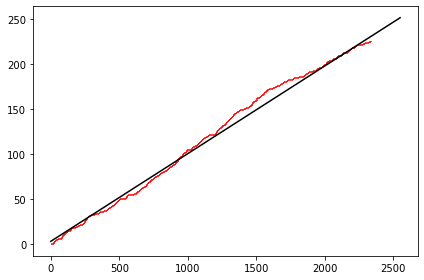

Delta-Mehta 3 for J=4 = 22.5930
Predicted = 0.5610 ± 0.1100
(A,B) = (0.1030, 11.7981)
Mean level-spacing = 8.7869


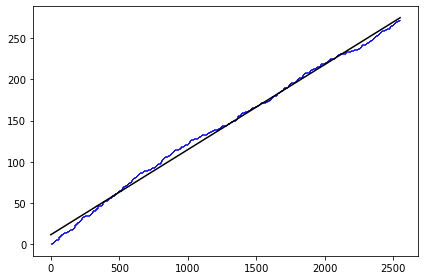

(A,B) = (0.2004, 15.2731)
Mean level-spacing = 4.9910


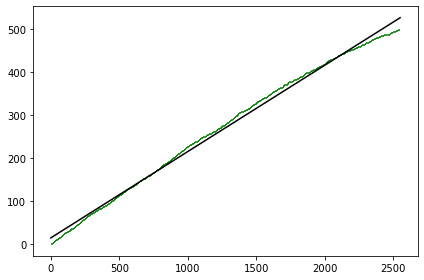

In [6]:
from scipy.optimize import minimize
def DeltaMehta3AB(X, XB:tuple, A:float, B:float):
    N  = len(X)
    H  = np.arange(N+1)
    Y  = A*X+B
    PB = (A*XB[0]+B, A*XB[1]+B-N)
    P1 = Y-H[:-1]
    P2 = Y-H[1:]
    return (np.sum(P1**3 - P2**3) + (PB[1]**3 - PB[0]**3))/(3*A*(XB[1]-XB[0]))
    # return (np.sum(P1**2 + P1*P2 + P2**2) + (A*(XB[1]-XB[0])-N)*(PB[1]**2+PB[1]*PB[0]+PB[0]**2))/(3*A*(XB[1]-XB[0]))
def DeltaMehta3(X, XB:tuple, MF:float=0.0):
    N = len(X)
    A0 = (1-MF)*N/(XB[1]-XB[0])
    def func(indvars):  return DeltaMehta3AB(X, XB, *indvars)
    sol  = minimize(func, x0=(A0,0))
    a,b = sol.x
    D3 = DeltaMehta3AB(X, XB, a, b)
    return D3, a, b
def PredictedDM3(n):
    return math.pi**(-2) * (math.log(n) - 0.0687)

D3A, AA, BA = DeltaMehta3(EA, Bounds, MissA)
D3B, AB, BB = DeltaMehta3(EB, Bounds, MissB)
D3E, AE, BE = DeltaMehta3(E, Bounds)
Xlimits = np.array(Bounds)

MLSA = (1-MissA)/AA
MLSB = (1-MissB)/AB

print(f'Delta-Mehta 3 for J=3 = {D3A:.4f}')
print(f'Predicted = {PredictedDM3(len(EA)):.4f} \u00B1 {0.11:.4f}')
print(f'(A,B) = ({AA:.4f}, {BA:.4f})')
print(f'Mean level-spacing = {MLSA:.4f}')

plt.figure()
plot_ecdf(EA, color='r')
plt.plot(Xlimits, AA*Xlimits+BA,'-k')
plt.tight_layout()
plt.show()

print(f'Delta-Mehta 3 for J=4 = {D3B:.4f}')
print(f'Predicted = {PredictedDM3(len(EB)):.4f} \u00B1 {0.11:.4f}')
print(f'(A,B) = ({AB:.4f}, {BB:.4f})')
print(f'Mean level-spacing = {MLSB:.4f}')

plt.figure()
plot_ecdf(EB, color='b')
plt.plot(Xlimits, AB*Xlimits+BB,'-k')
plt.tight_layout()
plt.show()

# print(f'Delta-Mehta 3 for all spin-groups = {D3E:.4f}')
# print(f'Predicted < {PredictedDM3(len(EA))+PredictedDM3(len(EB)):.4f} \u00B1 {0.156:.4f}')
print(f'(A,B) = ({AE:.4f}, {BE:.4f})')
print(f'Mean level-spacing = {1/AE:.4f}')

plt.figure()
plot_ecdf(E, color='g')
plt.plot(Xlimits, AE*Xlimits+BE,'-k')
plt.tight_layout()
plt.show()

Dyson Mehta 3 statistic performs subpar with this data set. There appears to be extra J=4+ resonances at 80 &lt; E &lt; 100. This may be partially due to misassignments or false resonances. ...

# Wigner Distribution

...

The missing level-spacing distribution uses higher order level-spacing distributions. Higher-Order Level-Spacing Distribution equations come from the following journal article:

https://journals.aps.org/pre/pdf/10.1103/PhysRevE.60.5371

10.1103/physreve.60.5371

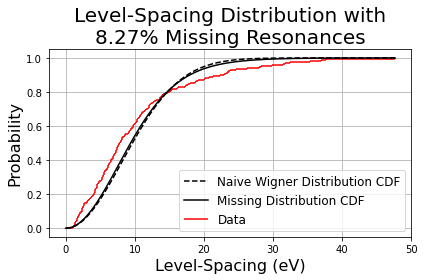

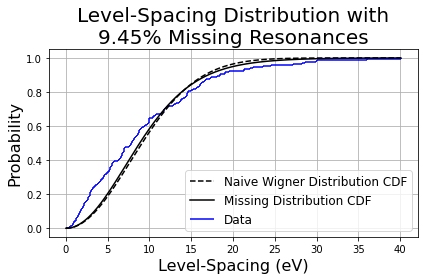

In [7]:
from scipy.special import gamma
from scipy.integrate import cumtrapz

def wigner(X, MLS=1.0):
    c = math.pi/(4*MLS**2)
    return 2*c*X*np.exp(-c*X**2)
def plot_wigner(LS, MLS=1.0, norm:bool=True):
    if norm:
        LS /= MLS
        plt.hist(LS, density=True)
        X = np.linspace(0.0, np.max(LS), 1000)
        Y = wigner(X)
        # plt.plot(X, Y, '-k', linewidth=2)
    else:
        plt.hist(LS, density=True)
        X = np.linspace(0.0, np.max(LS), 1000)
        Y = wigner(X, MLS)
        # plt.plot(X, Y, '-k', linewidth=2)
def WignerCDF(X, MLS:float=1.0):
    return 1.0-np.exp(-(math.pi/4) * (X/MLS)**2)
def high_order_level_spacing_pdf(X, n):
    a = (n**2 + 5*n + 2)/2
    g1 = gamma(a/2+1)
    g2 = gamma((a+1)/2)
    B = (g1 / ((n+1) * g2))**2
    A = 2 * B**((a+1)/2) / g2
    return A * X**a * np.exp(-B * X**2)
def missing_level_spacing_pdf(X, MLS:float=1.0, pM:float=0.0):
    return np.array([np.sum([pM**k * (1-pM) * high_order_level_spacing_pdf(x/MLS,k) for k in range(20)]) / MLS for x in X])
def missing_level_spacing_cdf(X, MLS:float=1.0, pM:float=0.0):
    return cumtrapz(missing_level_spacing_pdf(X, MLS, pM), X, initial=0.0)

LSA = np.diff(EA);  LSA.sort()
XA = np.linspace(0, np.max(LSA), 1000)
YA = missing_level_spacing_cdf(XA, MLSA, MissA)
WA = WignerCDF(XA, 1/AA)

LSB = np.diff(EB);  LSB.sort()
XB = np.linspace(0, np.max(LSB), 1000)
YB = missing_level_spacing_cdf(XB, MLSB, MissB)
WB = WignerCDF(XB, 1/AB)

plt.figure()
plot_ecdf(LSA, color='r', Density=True, label='Data')
plt.plot(XA, WA, '--k', label='Naive Wigner Distribution CDF')
plt.plot(XA, YA, '-k', label='Missing Distribution CDF')
plt.title(f'Level-Spacing Distribution with\n{100*MissA:.2f}% Missing Resonances', fontsize=20)
plt.xlabel('Level-Spacing (eV)', fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()

plt.figure()
plot_ecdf(LSB, color='b', Density=True, label='Data')
plt.plot(XB, WB, '--k', label='Naive Wigner Distribution CDF')
plt.plot(XB, YB, '-k', label='Missing Distribution CDF')
plt.title(f'Level-Spacing Distribution with\n{100*MissB:.2f}% Missing Resonances', fontsize=20)
plt.xlabel('Level-Spacing (eV)', fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()

...

It appears that the mean neutron width is the same for both spin-groups according to the given spin-group assignments. This seems to have been taken as an assumption. By looking at the distribution, there is a possibility of one mean width being higher and the other being lower.

# Mean Gamma Widths

...

Gamma Width        = 55.00000
Degrees of Freedom = 251.83452


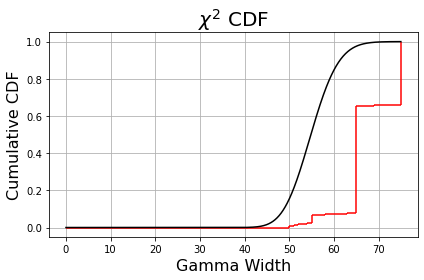

Gamma Width        = 67.61499
Degrees of Freedom = 251.83452


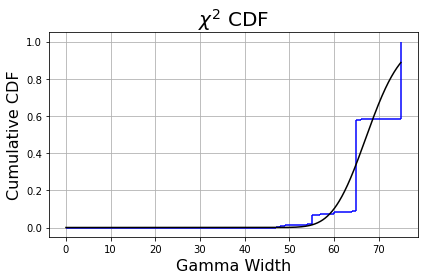

In [8]:
# def FitChi2(Gg, nu:int=None):
#     Ggm = np.mean(Gg)
#     dG = np.max(Gg)-Ggm
#     X = np.linspace(min(0, Ggm-5*dG), Ggm+5*dG, 10000)
#     Y = eval_ecdf(X, rGnA, Density=True)
#     if nu is None:
#         def func(X_, Ggm_, nu_):     return PorterThomasCDF(X_, Ggm_, nu=nu_)
#         params = curve_fit(func, X, Y, (Ggm, 100), bounds=((0.0, 1), (np.max(Gn), 1000)))[0]
#         return params[0], params[1]
#     else:
#         def func(X_, Ggm_):     return PorterThomasCDF(X_, Ggm_, nu=nu)
#         params = curve_fit(func, X, Y, Ggm, bounds=(0.0,np.max(Gn)))[0]
#         return params[0], nu

def FitChi2(X):
    M = np.mean(X)
    S = np.std(X)
    DoF = 2 * (M/S)**2
    return M, DoF


GgA = Gg[SG_type == 0];     GgA.sort()
GgB = Gg[SG_type == 1];     GgB.sort()

GgmA, nuA = FitChi2(GgA)
GgmB, nuB = FitChi2(GgA)

GgmA = 55

XA = np.linspace(0, np.max(GgA), 1000)
YA = PorterThomasCDF(XA, GgmA, nu=nuA)

XB = np.linspace(0, np.max(GgB), 1000)
YB = PorterThomasCDF(XA, GgmB, nu=nuA)

print(f'Gamma Width        = {GgmA:.5f}')
print(f'Degrees of Freedom = {nuA:.5f}')

plt.figure()
plot_ecdf(GgA, color='r', Density=True)
plt.plot(XA, YA, '-k')
plt.title(r'$\chi^2$ CDF', fontsize=20)
plt.xlabel('Gamma Width', fontsize=16)
plt.ylabel('Cumulative CDF', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'Gamma Width        = {GgmB:.5f}')
print(f'Degrees of Freedom = {nuB:.5f}')

plt.figure()
plot_ecdf(GgB, color='b', Density=True)
plt.plot(XB, YB, '-k')
plt.title(r'$\chi^2$ CDF', fontsize=20)
plt.xlabel('Gamma Width', fontsize=16)
plt.ylabel('Cumulative CDF', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

Like the mean neutron widths, the mean gamma widths are distributed similarly. This seems to align with theory.

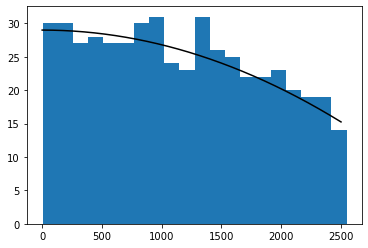

In [9]:
plt.figure()
plt.hist(E, bins=20)


X = np.linspace(0, 2500, 1000)
Y = 29 - 0.0000022*X**2
# Y = (1-PercentMissing(0.1*np.sqrt(X), 1, 1)) * 100
plt.plot(X,Y,'-k')

plt.show()